In [2]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim, cont2discrete,butter
from scipy.io import loadmat,savemat
import pysindy as ps
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import pickle
import control as ct

In [3]:
def bopdmd_train_test(svd_rank,num_trials,training_set,training_voltage,test_voltage,train_time,test_time,Btilde,return_training_fit, 
                     conjugate_bool, stable_bool, noise_level, evaluate,C,D):
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) #make our opt and bop objects with the correct
                                                            #number of trials and svd rank
        
        
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
#     rmse = mean_squared_error(training_set[:, 1], np.zeros(training_set[:, 1].shape), squared=False)
    training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)
    bopdmd.fit(training_set_func,train_time) #fit out data
    
    Atilde = bopdmd.A #get A matrix from bop
    
    
    
    #now we are going to see how well bop does on our test voltages. These will simulate a vacuum shot and
    #be a series of 3 state square waves that are fed into each of the four circuits
    if evaluate == True:
        tout,yout,xout = lsim((Atilde,Btilde,C,D),test_voltage,test_time)
    
        return Atilde,bopdmd,xout
    else:
        return Atilde,bopdmd
    
    if return_training_fit == True:
        tout_train,yout_train,xout_train = lsim((Atilde,Btilde,C,D),train_voltage,time)
        return xout_train
    

In [4]:
def make_graph(data,title,legend,impulse): #data should be a list of what one wants plotted,title is a string,
                                  #legend is an array of strings,impulse is a boolean if one is plotting the ringdown of a shot



    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey = 'row', figsize=(20, 15))

    fig.text(0.5, 0.04, 'Time (ms)', ha='center', fontsize = 20)
    fig.text(0.04, 0.25, 'Flux Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 15)
    fig.text(0.04, 0.5, 'Capacitor Voltage (V)', va='center', rotation='vertical', fontsize = 15)
    fig.text(0.04, 0.75, 'Series Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 15)
    fig.suptitle(title, fontsize = 40)
    if impulse == False:
        plt.xlim([0,4])
        time = experiment_time[251::]
    else:
        time = experiment_time[1772::]
    L1 = [0,3,6,9]
    C = [1,4,7,10]
    L2 = [2,5,8,11]
    
    colors = ['r','k']
    alphas = [1,.6]
    for i in range(len(L1)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+1)
            plt.plot(1000*time,np.real(j[:,L1[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()


    for i in range(len(C)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+5)
            plt.plot(1000*time,np.real(j[:,C[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()

    for i in range(len(L2)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+9)
            plt.plot(1000*time,np.real(j[:,L2[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()



    fig.legend(legend, fontsize = 15)



In [5]:
filename = 'continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D

print(np.shape(D))

object successfully saved to continuous_vacuum_ss_model
(4, 4)


In [6]:
def load_vacuum_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 
                             
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
    state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list, experiment_time




In [7]:
directory = "data/vacuum_shots_220816/good_shots"
trajectory_list,inputs_list,state_deriv_list,experiment_time = load_vacuum_shot(directory)

(12, 484)


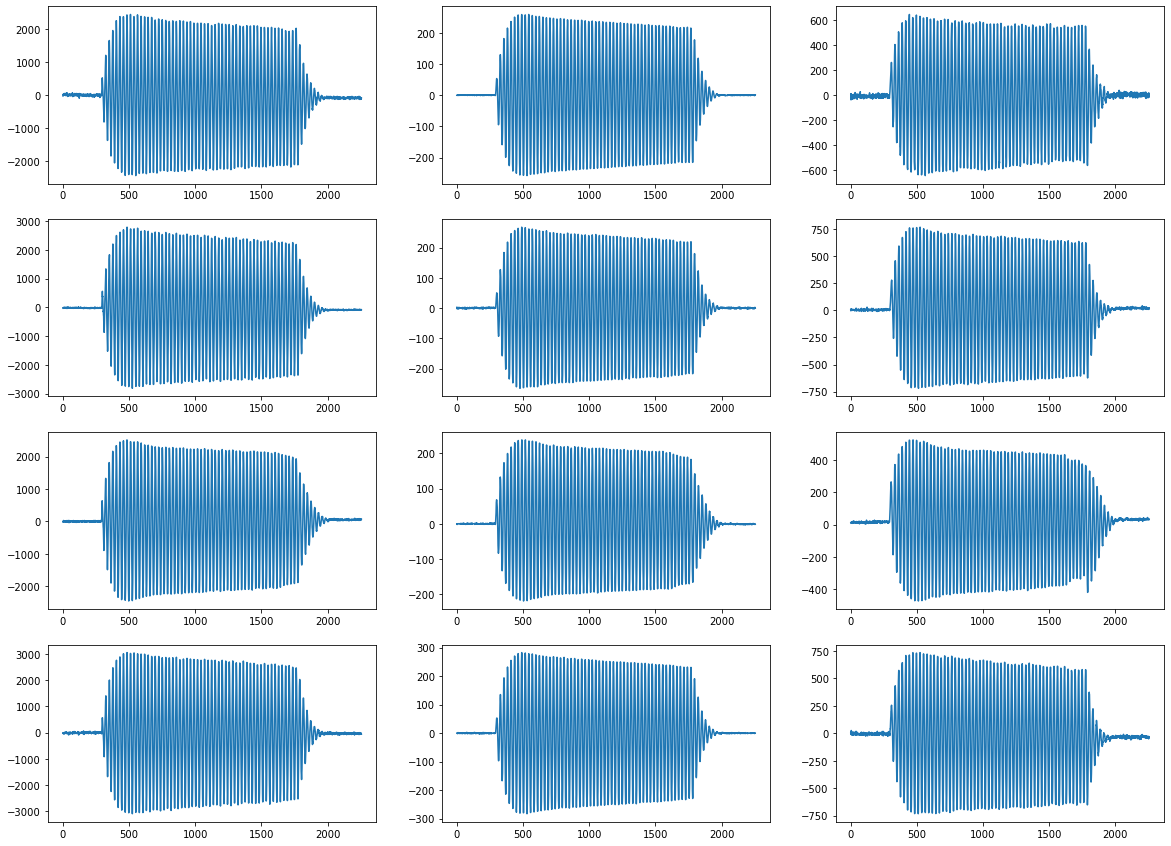

In [8]:
plt.figure(figsize = (20,15))

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(trajectory_list[2][:,i])
    
    
xout_train = trajectory_list[2][1772::,:]
tout_train = experiment_time[1772::].reshape(len(experiment_time[1772::]))

print(np.shape(xout_train.T))

## Great idea from Chris: what if we take the very end of the vacuum shot in which it sort of appears that the circuits were hit by an impulse and are now decaying

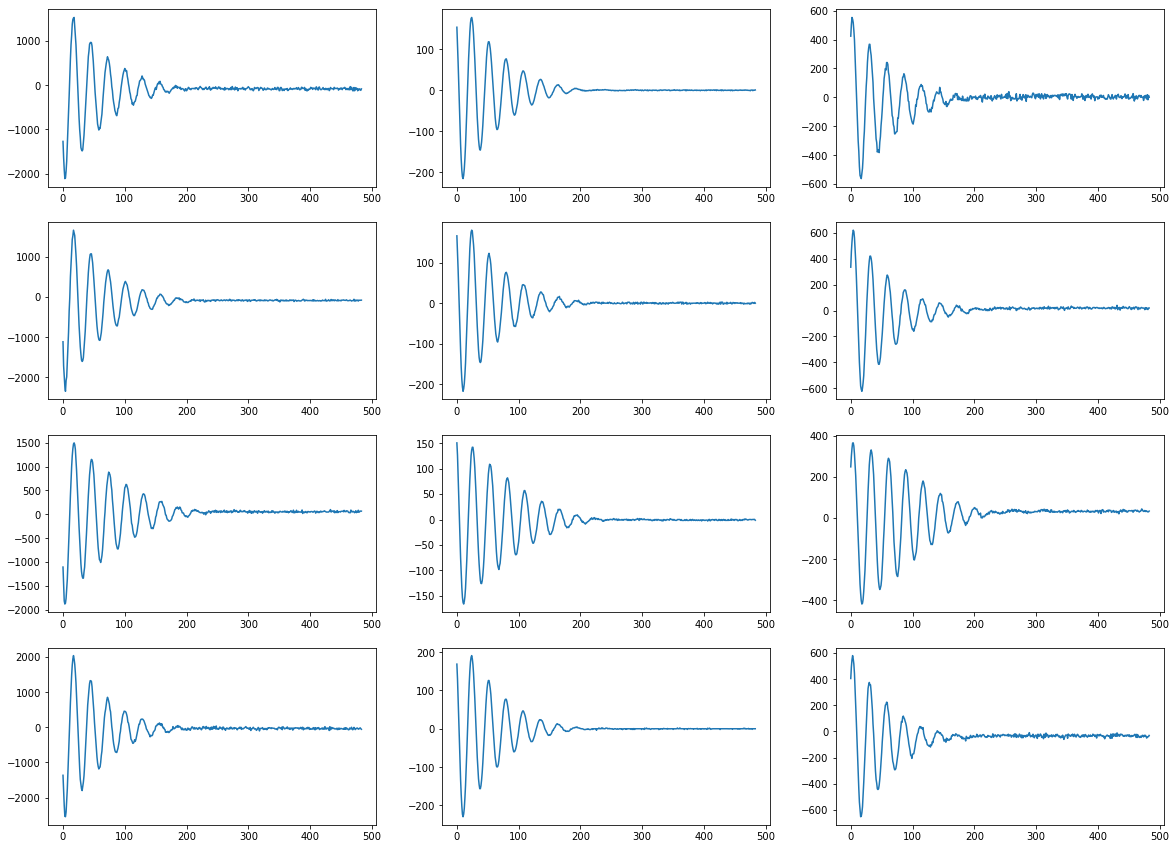

In [9]:
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_train[:,i])

## No complex conjugate orstability enforcement in this one

In [17]:
np.shape(tout_train)


xout_list = []
Atilde_list = []
bop_list = []



for i in range(12):

    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = xout_train.T, #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][251::,:],
        train_time = tout_train,
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = False,
        noise_level = 0,
        evaluate = True)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:287: RuntimeWarning: overflow encountered in exp
  return np.exp(np.outer(t, alpha))


LinAlgError: SVD did not converge in Linear Least Squares

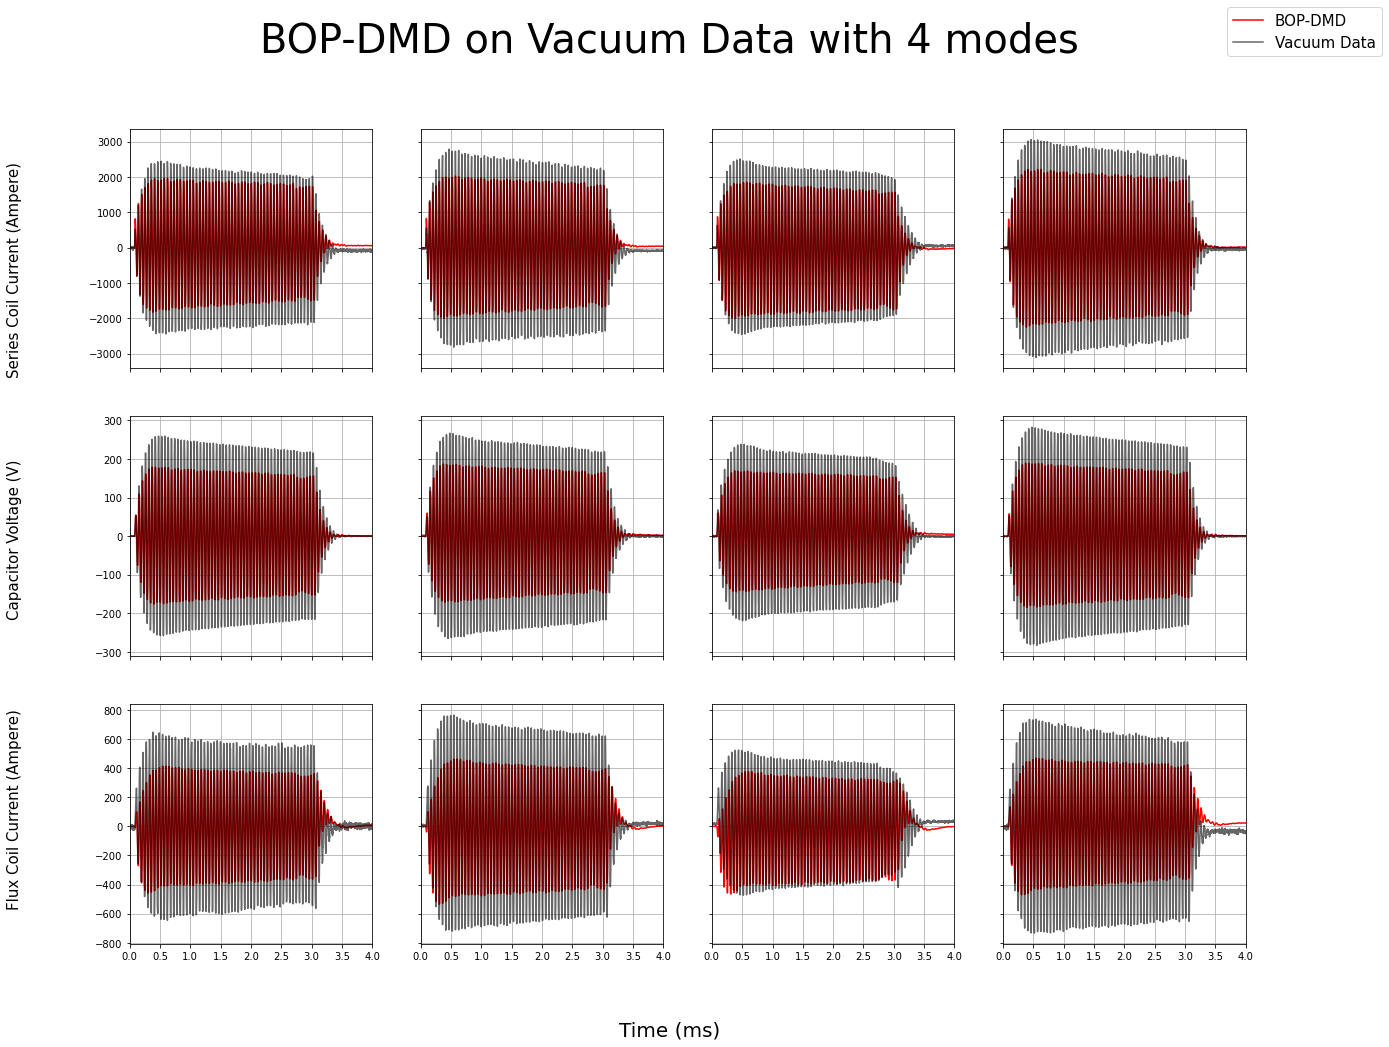

In [19]:
make_graph([np.real(xout_list[4]),trajectory_list[2][251::,:]],'BOP-DMD on Vacuum Data with 4 modes',
           ['BOP-DMD','Vacuum Data'],impulse = False)

## Just stable eigs in this one

In [23]:
np.shape(tout_train)


xout_list = []
Atilde_list = []
bop_list = []



for i in range(12):

    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = xout_train.T, #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][251::,:],
        train_time = tout_train,
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))


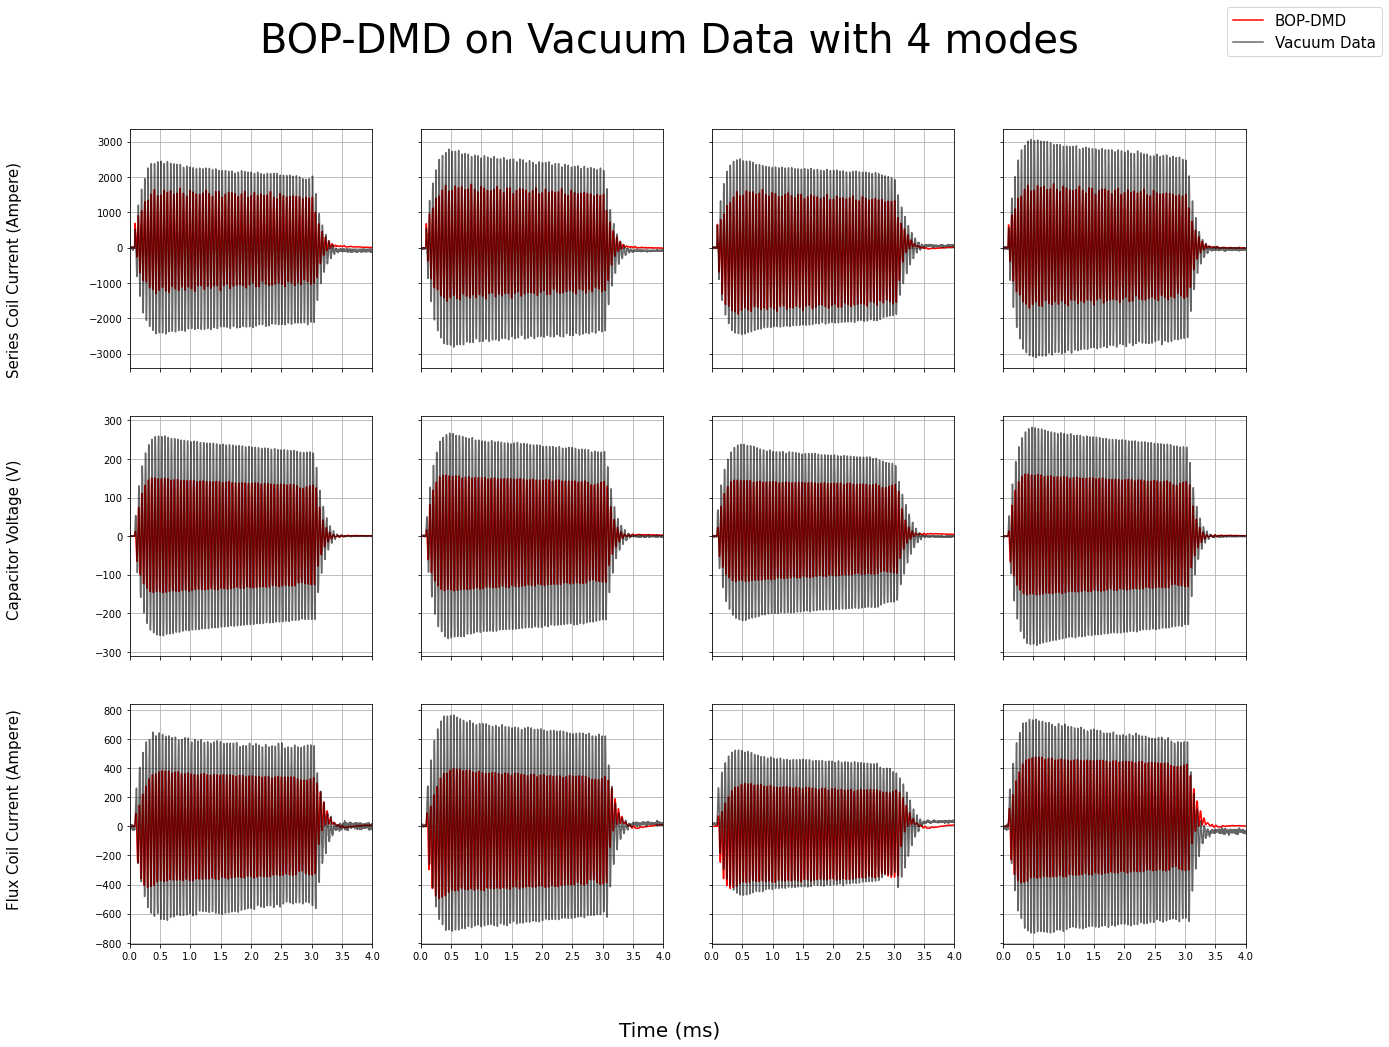

In [24]:
make_graph([np.real(xout_list[4]),trajectory_list[2][251::,:]],'BOP-DMD on Vacuum Data with 4 modes',
           ['BOP-DMD','Vacuum Data'],impulse = False)

In [10]:
np.shape(tout_train)


xout_list = []
Atilde_list = []
bop_list = []


for i in range(12):

    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = xout_train.T, #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][251::,:],
        train_time = tout_train,
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))


In [11]:
print(np.shape(xout_list[0]))

(2005, 12)


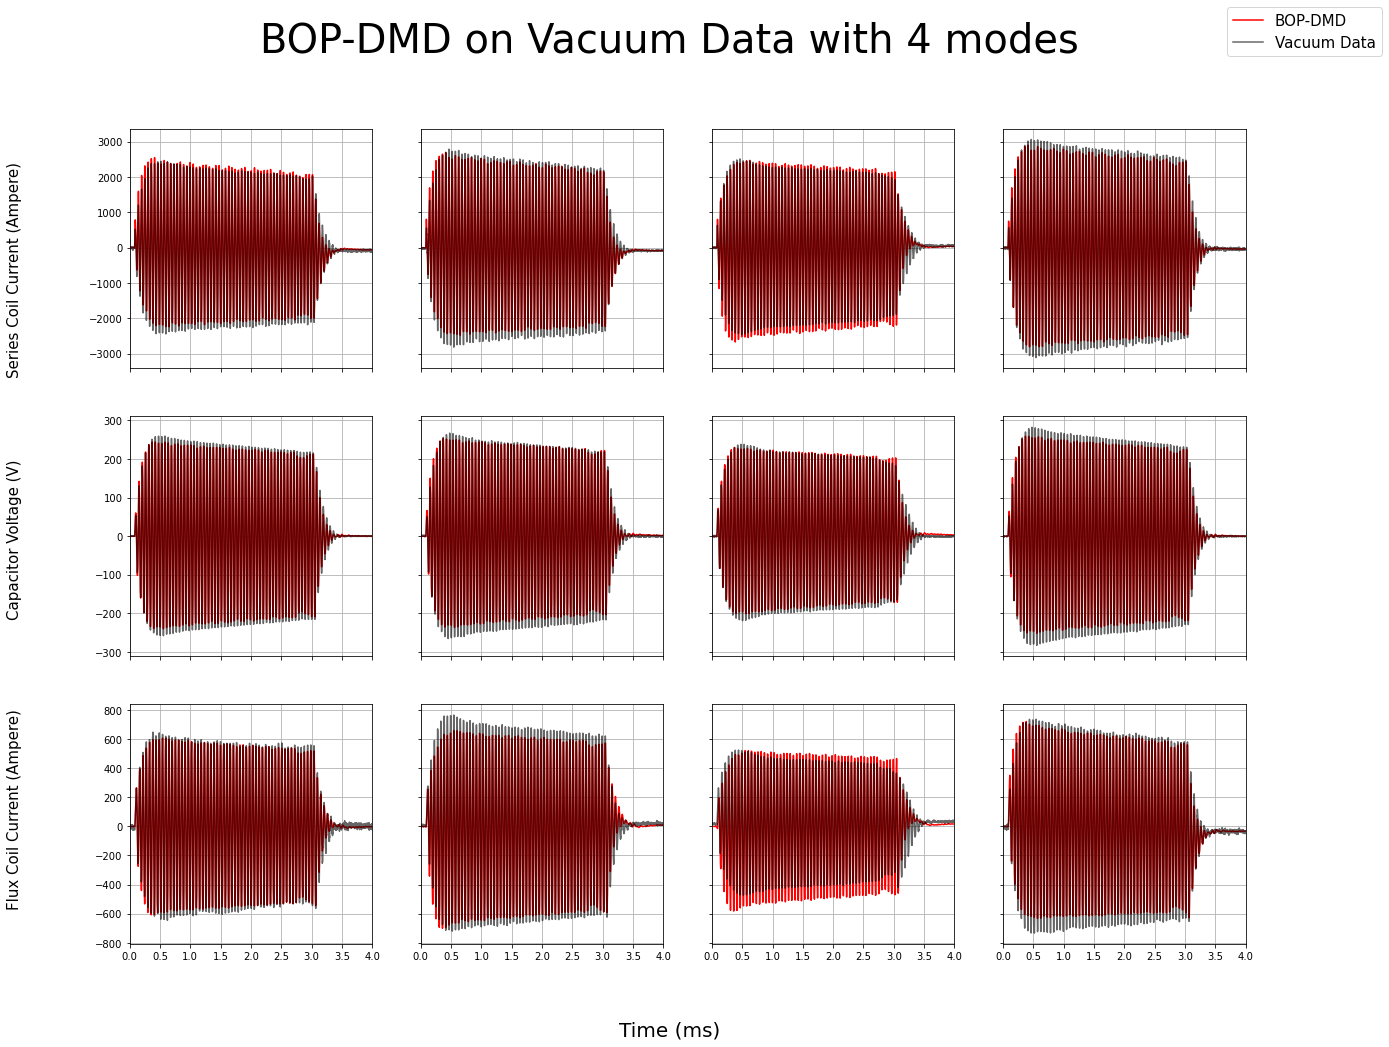

In [16]:
make_graph([np.real(xout_list[4]),trajectory_list[2][251::,:]],'BOP-DMD on Vacuum Data with 4 modes',
           ['BOP-DMD','Vacuum Data'],impulse = False)

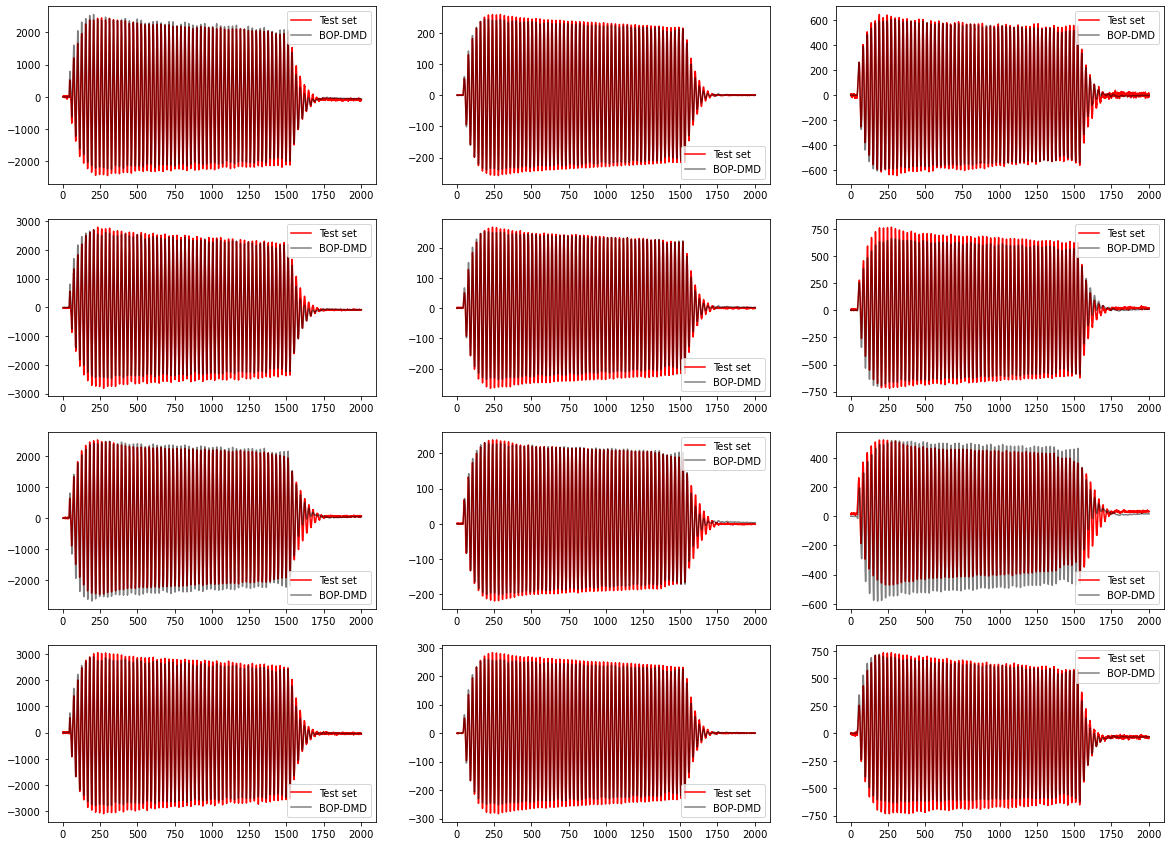

In [12]:
num = 4 #modes - 1



plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(trajectory_list[2][251::,i],'r')
    plt.plot(np.real(xout_list[num][:,i]),'k', alpha=.5)

    plt.legend(['Test set','BOP-DMD'])
    


In [13]:
bop_dict = {'matrix':Atilde_list[4],'label': 'BOP'}

dmd_A = savemat('BOP_A_matrix.mat',bop_dict)

## This model also extrapolates to a totally different vacuum shot really well

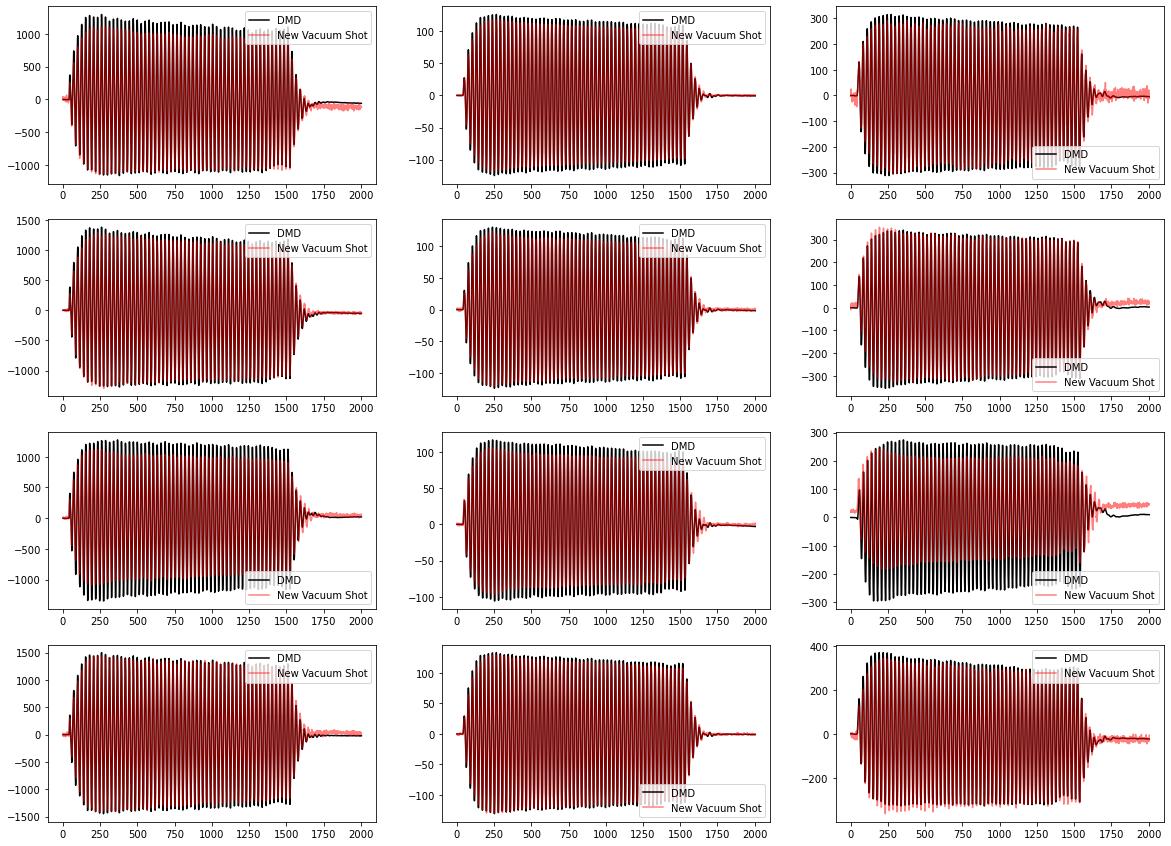

In [15]:
tout,yout,xout = lsim((Atilde_list[4],B,C,D),inputs_list[1][251::,:],experiment_time[251::])

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout[:,i]),'k')
    plt.plot(trajectory_list[1][251::,i],'r',alpha = .5)
    plt.legend(['DMD','New Vacuum Shot'])

[-7.56001161e+03-1.13293392e+05j -7.56001161e+03+1.13293392e+05j
 -6.84227360e+03-8.50240781e+03j -6.84227360e+03+8.50240781e+03j
 -1.41113730e+03-1.31651718e-12j -3.56046175e-11+8.97996660e-13j
  2.17741201e-11+5.26241085e-12j  5.60420685e-12-1.08586316e-11j
 -1.09447579e-11-1.09745973e-12j -1.15189077e-12+5.63501829e-12j
  4.33661317e-12-1.64657931e-12j  1.11431554e-12+9.65112179e-13j]


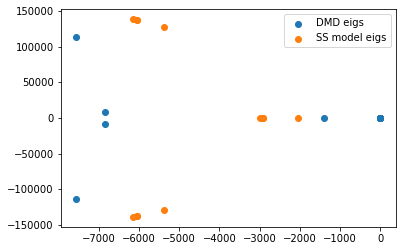

In [21]:
plt.scatter(np.real(np.linalg.eigvals(Atilde_list[4])),np.imag(np.linalg.eigvals(Atilde_list[4])))
plt.scatter(np.real(np.linalg.eigvals(A)),np.imag(np.linalg.eigvals(A)))
plt.legend(['DMD eigs','SS model eigs'])
print(np.linalg.eigvals(Atilde_list[4]))

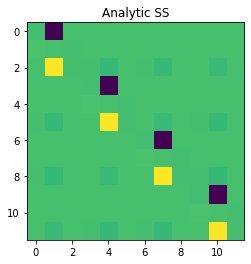

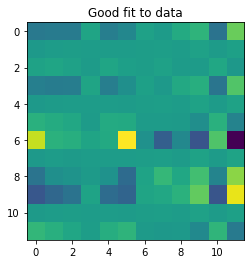

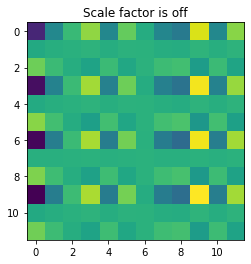

In [22]:



plt.figure()
plt.title('Analytic SS')
plt.imshow(A)
plt.figure()
plt.title('Good fit to data')
plt.imshow(np.real(Atilde_list[9]))
plt.figure()
plt.title('Scale factor is off')
plt.imshow(np.real(Atilde_list[5]))

## Comparison to SINDy

In [32]:
u = inputs_list[2]
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)
optimizer_stable = ps.StableLinearSR3(
    threshold=0.0,
    thresholder='l1',
    nu=1e-7,
    max_iter=10000,
    tol=1e-5,
    verbose=True,
    ensemble = True
)

model = ps.SINDy(feature_library=sindy_library, optimizer=optimizer_stable)
model.fit(trajectory_list[2][] = , t=experiment_time[1772::], u=u[1772::,::])

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 6.1176e+20 ... 8.4565e+19 ... 0.0000e+00 ... 6.1176e+20
      1000 ... 4.7657e+19 ... 2.0207e+18 ... 0.0000e+00 ... 4.7657e+19
      2000 ... 4.7656e+19 ... 2.0133e+18 ... 0.0000e+00 ... 4.7656e+19
      3000 ... 4.7656e+19 ... 2.0130e+18 ... 0.0000e+00 ... 4.7656e+19
      4000 ... 4.7656e+19 ... 2.0130e+18 ... 0.0000e+00 ... 4.7656e+19
      5000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      6000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      7000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      8000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      9000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19


C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converge after 10000 iterations.
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=1, include_bias=False),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'u0', 'u1', 'u2', 'u3'],
      optimizer=StableLinearSR3(max_iter=10000, nu=1e-07, threshold=0.0,
                                verbose=True))

In [33]:
Xi = model.coefficients()
r = Xi.shape[0]
B_SINDy = Xi[:r, r:]
A_SINDy = Xi[:r, :r]

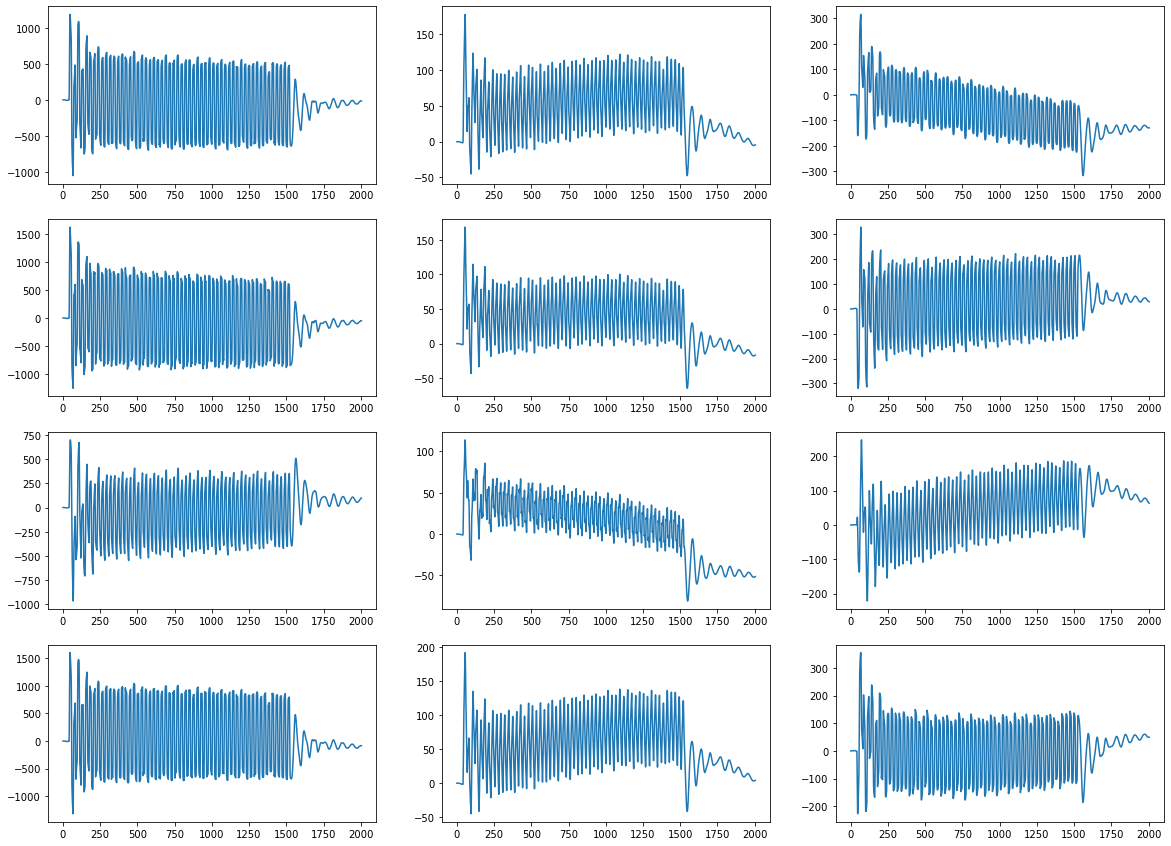

In [34]:
tout,yout,xout_sindy = lsim((A_SINDy,B_SINDy,C,D),inputs_list[2][251::,:],experiment_time[251::])

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_sindy[:,i])

## Damn dog this actually looks pretty good! (not SINDy...)

In [305]:
def load_plasma_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 
                                 #One important change is that for a plasma shot we will look at the voltage, not the flux circuits
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4','i_tor']
    state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))



    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list




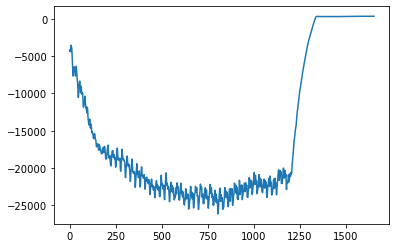

In [307]:
directory = 'data/plasma_shots/220816009'

plasma_trajectory_list,plasma_inputs_list,plasma_state_deriv_list = load_plasma_shot(directory)


#Ayyy we got a plasma current
plt.plot(plasma_trajectory_list[0][600::,12])



(13, 2256)
[-3.64192854]


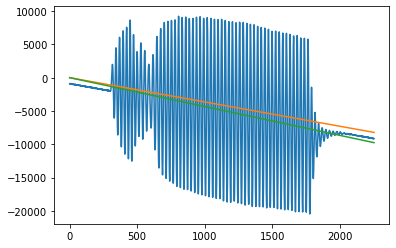

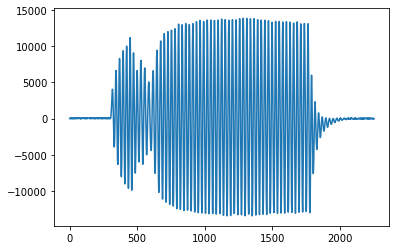

In [308]:
print(np.shape(plasma_trajectory_list[0].T))


vcoil_3 = plasma_trajectory_list[0][:,8].reshape(len(plasma_trajectory_list[0][0::,8]),1)

linear_fit = (vcoil_3[-1] - vcoil_3[0])/(len(vcoil_3))

print((linear_fit))

plt.plot(vcoil_3)
plt.plot(linear_fit*np.arange(len(vcoil_3)))

n = np.arange(len(vcoil_3)).reshape(len(vcoil_3),1)

lstsq_fit = np.linalg.pinv(n)@vcoil_3

plt.plot(lstsq_fit*n)

plt.figure()
plt.plot((vcoil_3 - (linear_fit*n))-vcoil_3[0])

#Linear fit looks good, and we subtracted off the offset

plasma_trajectory_list[0][:,8] = ((vcoil_3 - (linear_fit*n))-vcoil_3[0]).reshape(len(vcoil_3))

In [1]:
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(experiment_time,flux_plasma_trajectory_list[0][:,i])
plt.figure()
# plt.plot(plasma_trajectory_list[0][1500:1800,12])

NameError: name 'plt' is not defined

In [310]:
Atilde_plasma_list = []
bop_plasma_obj_list = []
for i in range(30):
    [Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = plasma_trajectory_list[0].T[:,251::], #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][251::,:],
        train_time = experiment_time[251::],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = False)
    Atilde_plasma_list.append(Atilde)
    bop_plasma_obj_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:534: RuntimeWarning: invalid value encountered in true_divide
  improvement_ratio = actual_improvement / pred_improvement


(13, 2005)


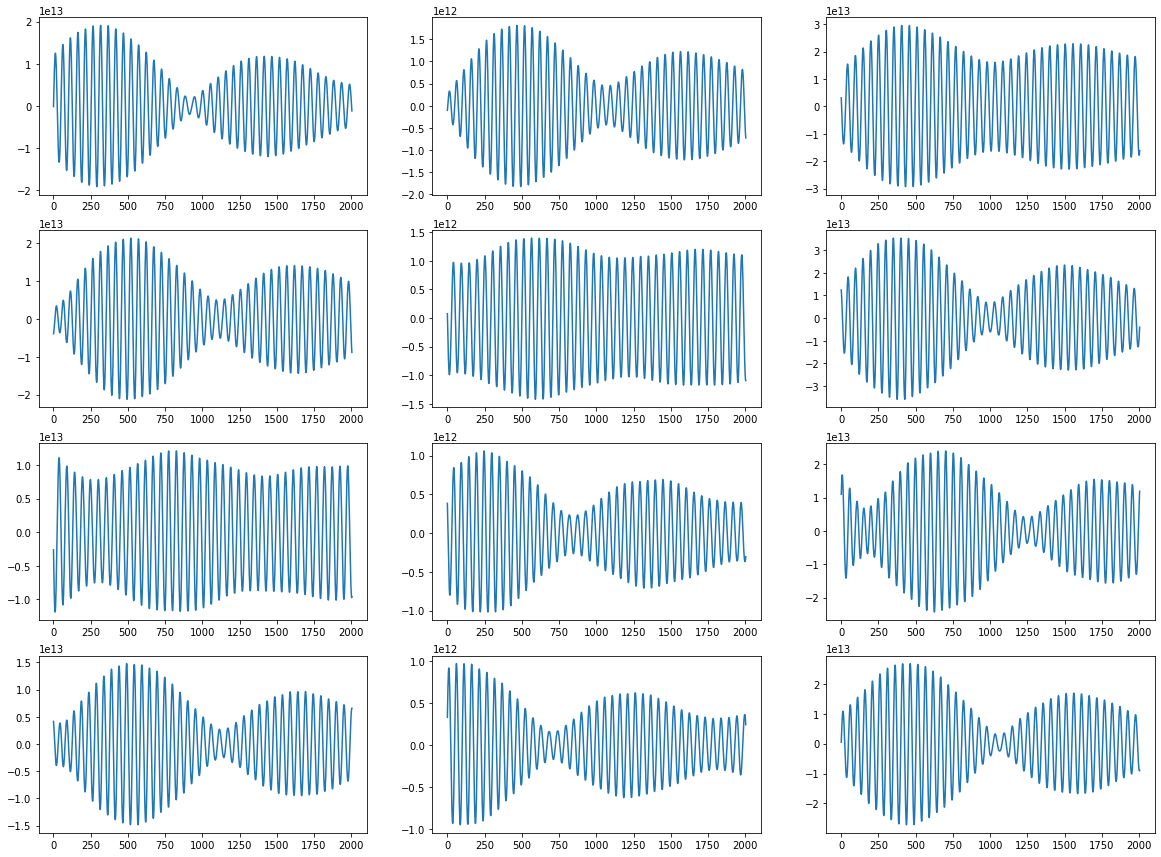

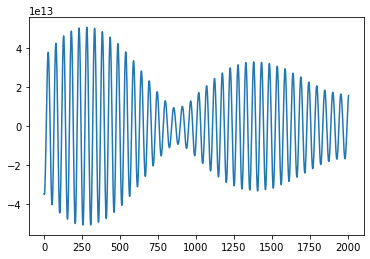

In [311]:
num = 11
bopdmd_states = np.real(bop_plasma_obj_list[num].modes@bop_plasma_obj_list[num].dynamics)

print(np.shape(bopdmd_states))

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(bopdmd_states[i,:])

plt.figure()
plt.plot(bopdmd_states[12,:])

C:\Users\ducks\anaconda3\lib\site-packages\numpy\ma\core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
C:\Users\ducks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\ducks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<StemContainer object of 3 artists>

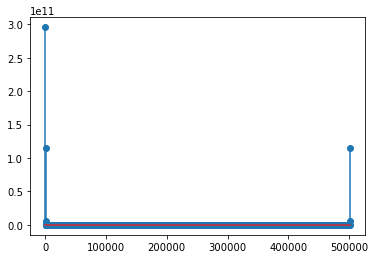

In [312]:
dt = len(experiment_time)/(np.max(experiment_time) - np.min(experiment_time))

N = len(experiment_time)
n = np.arange(N)
T = N/dt
freq = n/T


plasma_freq = np.fft.fft(plasma_trajectory_list[0][:,12],N)
PSD = plasma_freq * np.conj(plasma_freq) / N #power spectral density



plt.stem(freq,PSD)

19


C:\Users\ducks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


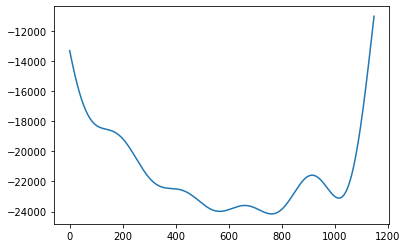

In [313]:
sorted_PSD = np.flip(np.sort(PSD))

#Let's take the frequencies above 1e11 from frequencies below 100000 Hz
print(sum(i > 1e8 for i in PSD))
indices = PSD > 1e8
PSD_new = PSD*indices

plasma_freq_new = indices * plasma_freq

recon_signal = np.fft.ifft(plasma_freq_new)

plt.plot(recon_signal[700:1850]) # You can check but this is a really good reconstruction of the plasma current
#plt.plot(plasma_trajectory_list[0][:,12])

In [314]:
Atilde_plasma_list = []
bop_plasma_obj_list = []
for i in range(30):
    [Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = np.vstack( (plasma_trajectory_list[0].T[0:12,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][700:1850,:],
        train_time = experiment_time[700:1850],
        test_time = experiment_time[700:1850], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = False,
        noise_level = 0,
        evaluate = False)
    Atilde_plasma_list.append(Atilde)
    bop_plasma_obj_list.append(bop_obj)

C:\Users\ducks\AppData\Local\Temp/ipykernel_16016/3863896744.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)


(13, 1150)


C:\Users\ducks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


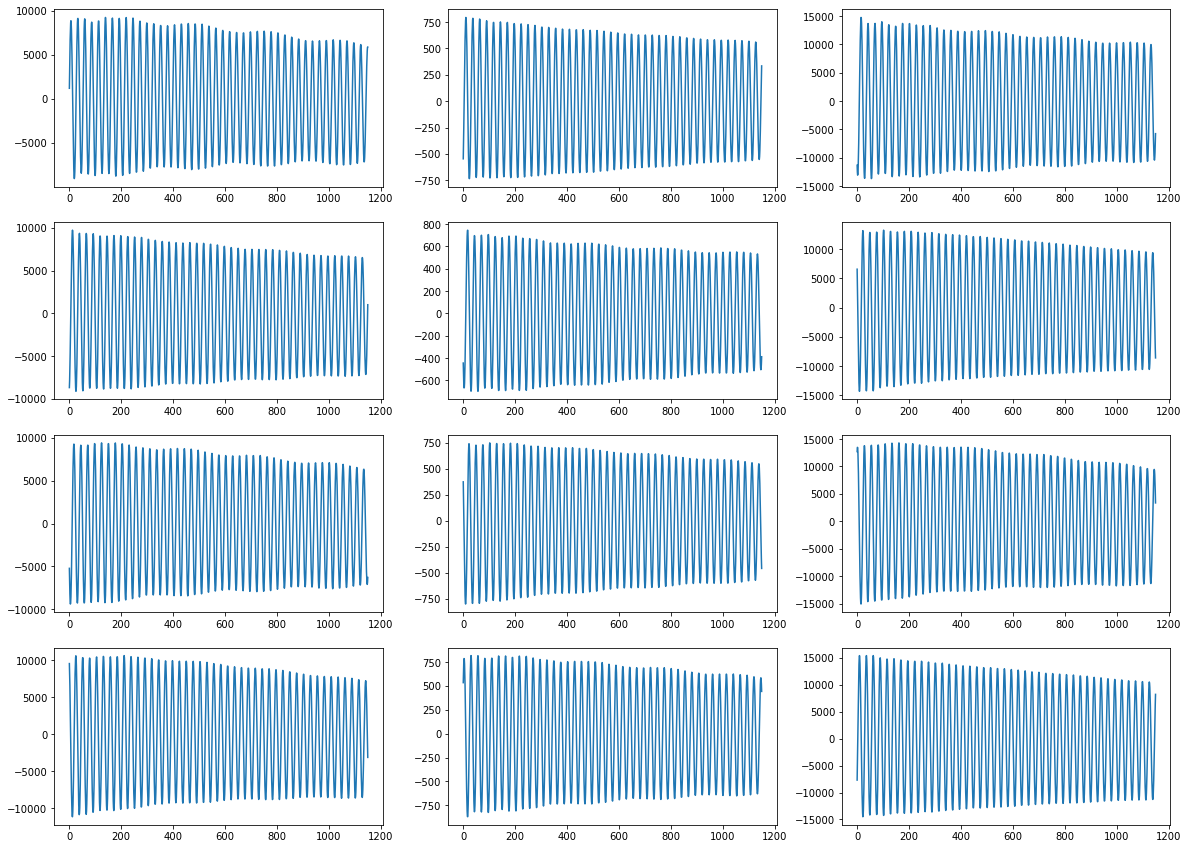

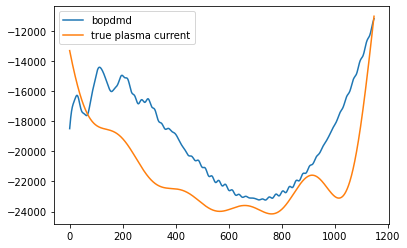

In [315]:
num = 8

bopdmd_states = np.real(bop_plasma_obj_list[num].modes@bop_plasma_obj_list[num].dynamics)

print(np.shape(bopdmd_states))

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(bopdmd_states[i,:])

plt.figure()
plt.plot(bopdmd_states[12,:])
plt.plot(recon_signal[700:1850])
plt.legend(['bopdmd','true plasma current'])

## So this is pretty interesting: when I train on the plasma portion of the shot (500 snapshots in the middle), and then I see when BOP does best, it actually looks like it's at 12 modes. => That the plasma current is linearly dependent on the injector currents and voltages => it can be well modeled by only looking at the injector dynamics. 

(2256, 12)


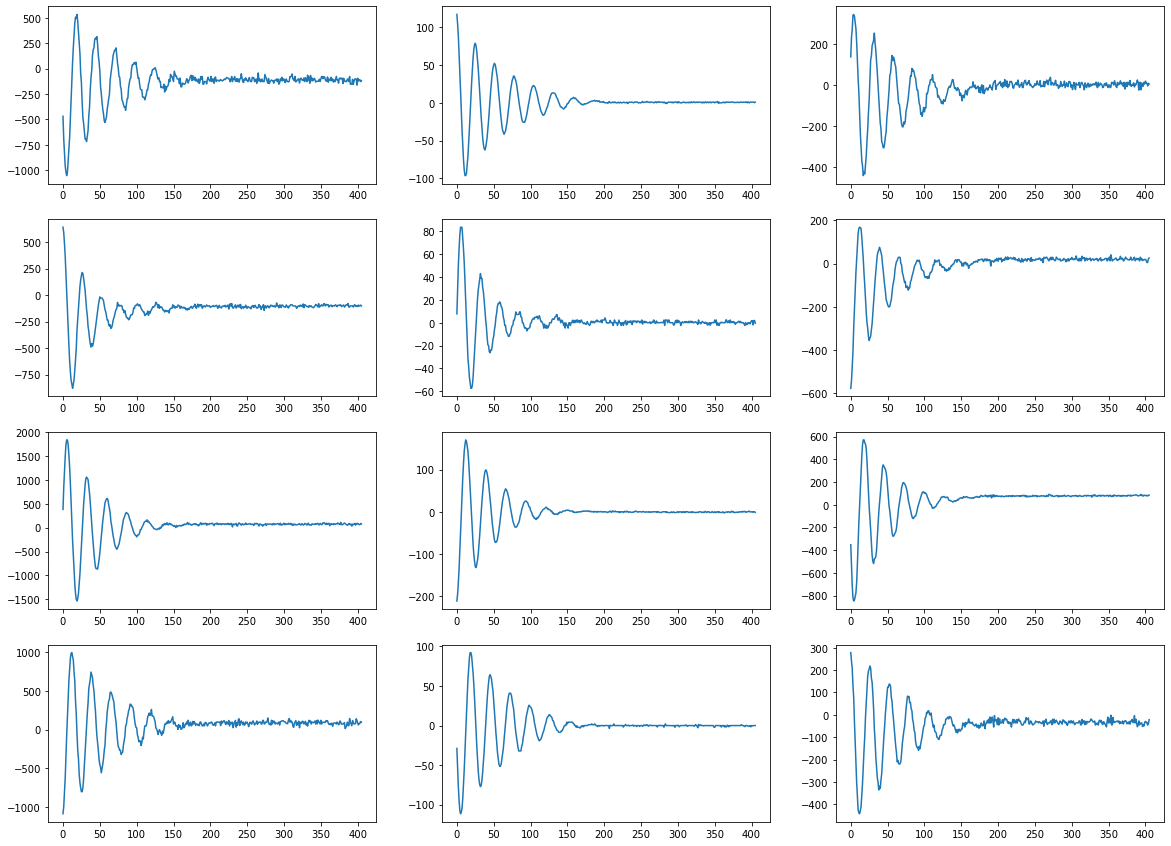

In [317]:
flux_plasma_trajectory_list,flux_plasma_inputs_list,flux_plamsa_state_deriv_list,flux_plasma_experiment_time = load_vacuum_shot(directory='data/plasma_shots/flux_data/220816009')

print(np.shape(flux_plasma_trajectory_list[0]))

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(flux_plasma_trajectory_list[0][1850::,i])

In [318]:
full_injector_list = []
full_injector_list.append( np.hstack((flux_plasma_trajectory_list[0],plasma_trajectory_list[0])) )

full_inputs_list = []
full_inputs_list.append( np.hstack((flux_plasma_inputs_list[0],plasma_inputs_list[0])) )

print(np.shape(full_injector_list[0]))
print(np.shape(full_inputs_list[0]))

# plt.plot(full_injector_list[0][:,23])

(2256, 25)
(2256, 8)


## So now I've stacked together the flux, and voltage circuits and I'm going to try DMD on the ring down of the shot, and on the plasma portion in the middle.

In [319]:
Atilde_injector_list = []
bop_injector_obj_list = []
for i in range(30):
    [Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = full_injector_list[0].T[:,700:1850], #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = full_inputs_list[0][700:1850,:],
        train_time = experiment_time[700:1850],
        test_time = experiment_time[700:1850], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = False)
    Atilde_injector_list.append(Atilde)
    bop_injector_obj_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag


30
(25, 1150)


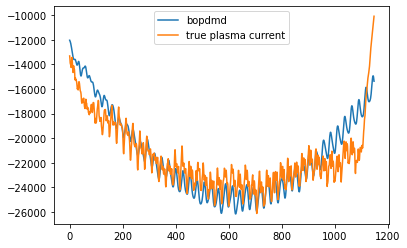

In [320]:
print(len(Atilde_injector_list))

num = 21
bopdmd_injector_states = np.real(bop_injector_obj_list[num].modes@bop_injector_obj_list[num].dynamics)

print(np.shape(bopdmd_injector_states))

# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(bopdmd_injector_states[i,:])

plt.figure()
plt.plot(bopdmd_injector_states[24,:])
plt.plot(full_injector_list[0][700:1850,24])
plt.legend(['bopdmd','true plasma current'])

In [321]:
#need to modify our B matrix

B_full = np.zeros((25,8))

B_full[0:12,0:4] = B
B_full[12:24,4:8] = B

C_full = np.zeros((8,25))
D_full = np.zeros((8,8))

print(np.shape(full_inputs_list[0][251::,:]))

(2005, 8)


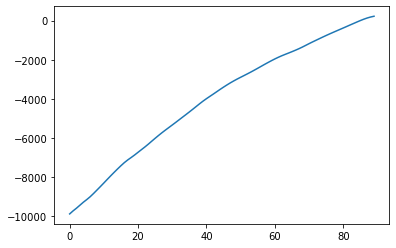

In [322]:
plt.plot(full_injector_list[0][1850:1940,24])

Atilde_ringdown_list = []
bop_ringdown_obj_list = []
xout_full_injector_list = []
for i in range(40):
    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = plasma_trajectory_list[0].T[0:13,1900:2000], #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = plasma_inputs_list[0][1900:2000,:],
        test_voltage = plasma_inputs_list[0][251::,:],
        train_time = experiment_time[1900:2000],
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = np.vstack((B,np.zeros((1,4)))),
        C = np.hstack((C,np.zeros((4,1)))),
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    Atilde_ringdown_list.append(Atilde)
    bop_ringdown_obj_list.append(bop_obj)
    xout_full_injector_list.append(xout)

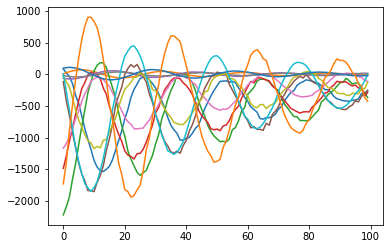

In [323]:
plt.plot(plasma_trajectory_list[0][1900:2000,0:12])

(13, 100)


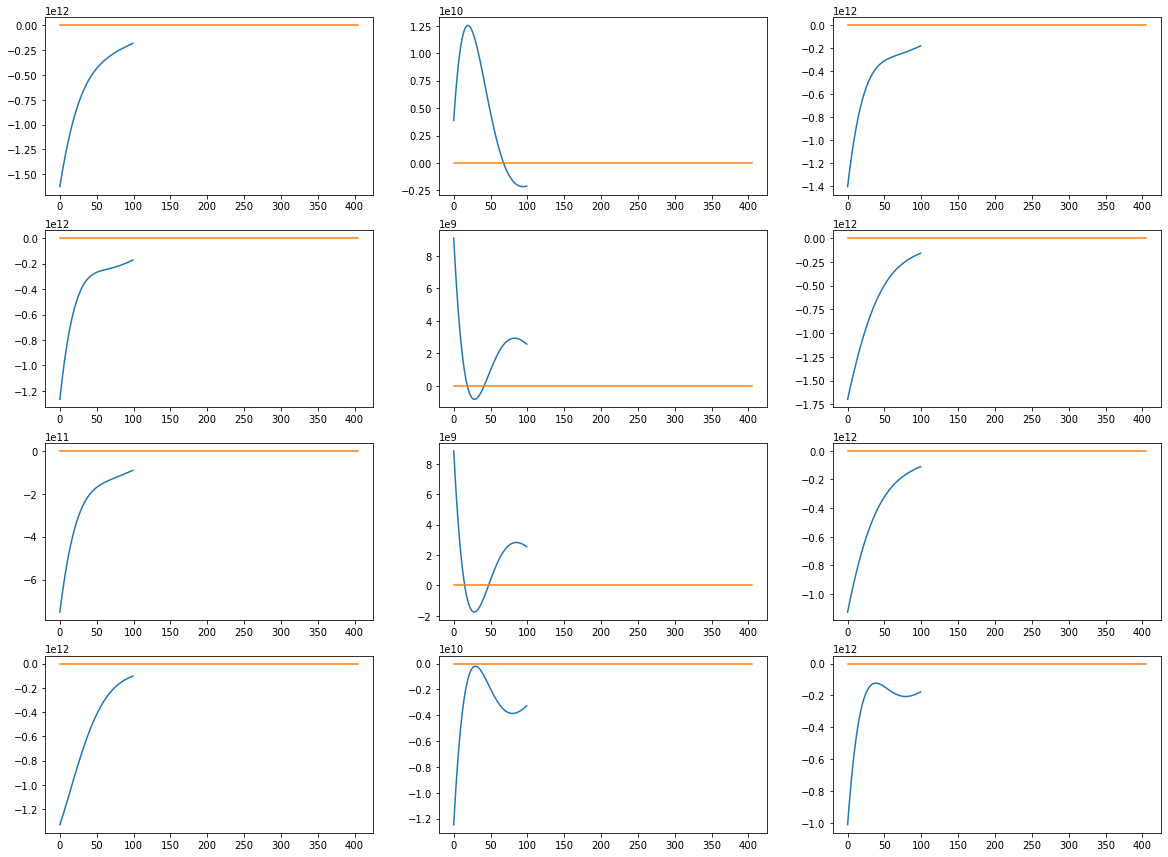

In [324]:
num = 2
bopdmd_states = np.real(bop_ringdown_obj_list[num].modes@bop_ringdown_obj_list[num].dynamics)

print(np.shape(bopdmd_states))

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(bopdmd_states[i,:])
    plt.plot(plasma_trajectory_list[0].T[i,1850:])
    


(2005, 13)
(2005, 13)


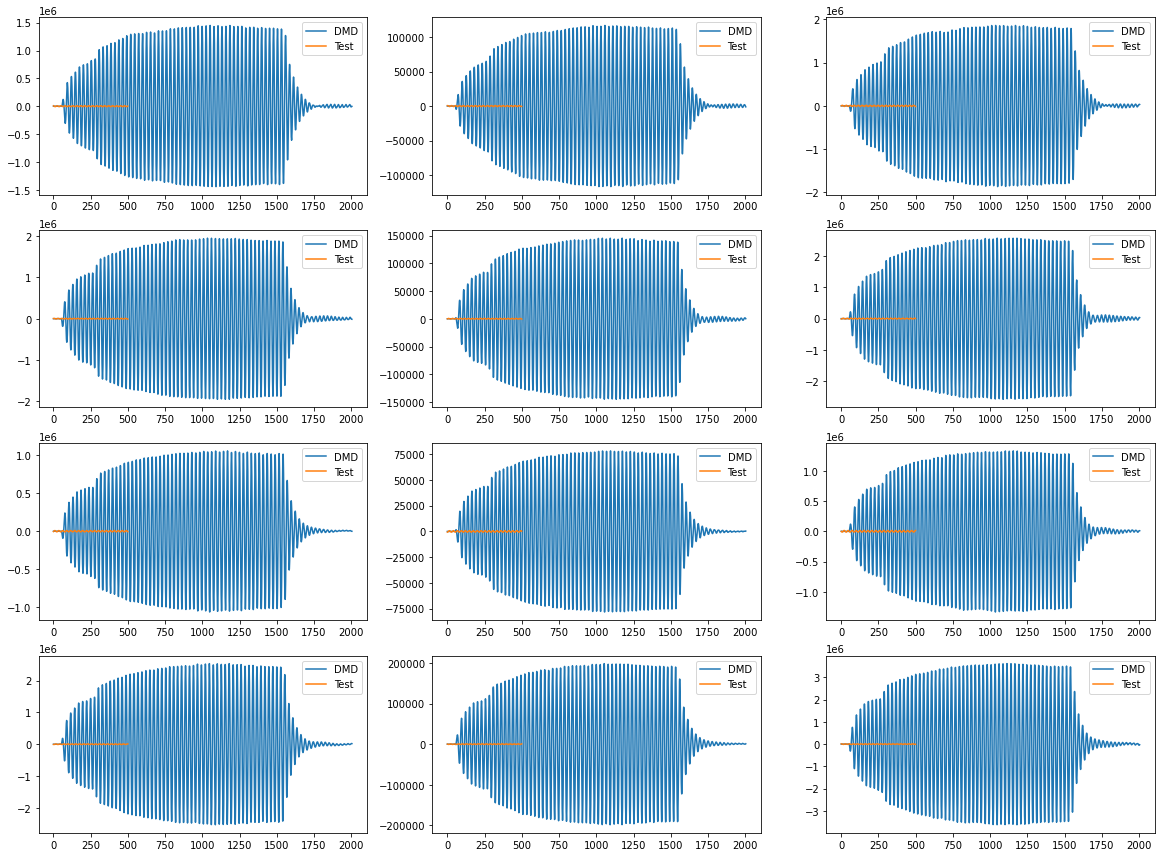

In [329]:
num = 30
print(np.shape(xout_full_injector_list[0]))
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout_full_injector_list[num][:,i]))
    plt.plot(plasma_trajectory_list[0][1000:1500,i])
    plt.legend(['DMD','Test'])
print(np.shape(xout_full_injector_list[0]))

In [326]:
print(np.shape(xout_full_injector_list))

(40, 2005, 13)


In [327]:
print(np.linalg.eigvals(Atilde_ringdown_list[num]))

[  -673.4144277 +250722.46701484j    -40.40687651-249300.70104055j
  -8218.57577956+116655.94401334j  -1860.71175168+126524.70302626j
  -1615.71369024-125754.29148779j  -7677.03073161-116869.75727493j
 -23854.04000583 +68549.66336552j -23133.96708961 -67600.12694707j
  -1846.47629242 -17000.23532589j   -336.83429261 +14806.07923649j
  -4995.05112282  -7578.16939493j  -4721.13531611  +6835.82686663j
  -1054.2675458    +614.83294846j]


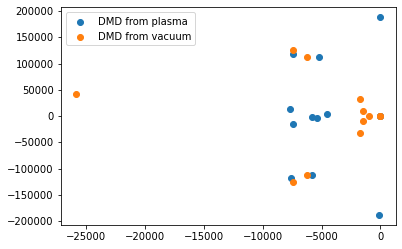

In [328]:
num = 10
plt.scatter(np.real(np.linalg.eigvals(Atilde_ringdown_list[num])),np.imag(np.linalg.eigvals(Atilde_ringdown_list[num])))
plt.scatter(np.real(np.linalg.eigvals(Atilde_list[num])),np.imag(np.linalg.eigvals(Atilde_list[num])))
plt.legend(['DMD from plasma','DMD from vacuum'])